# Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import json
from datetime import datetime
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization,Dropout

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import statsmodels.api as sm
from statsmodels.formula.api import ols, glm
import xgboost as xgb
from catboost import CatBoostRegressor

from scipy.special import boxcox1p, inv_boxcox1p
from scipy import stats
from scipy.stats import norm, skew

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import PolynomialFeatures

import lightgbm as lgb
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, Ridge

import optuna 
import joblib
from optuna import Trial, visualization
from optuna.samplers import TPESampler

import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.5f' % x)

sns.set_style("white")
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)
plt.rcParams['figure.figsize'] = [16.0, 10.0]

In [11]:
dates = [
    '201902', '201903', '201904', '201905', '201907', '201908', '201909',
    '201910', '201911', '202001', '202002', '202003', '202004', '202005',
    '202007', '202008', '202009', '202010', '202011'
]
seed=111
p = 0.2
bc_dataframe = []
for date in dates:
    df = pd.read_csv(
             f"train_{date}_cleaned.csv",
             header=0,
             skiprows=lambda i: i>0 and random.random() > p
    ).drop("Unnamed: 0", axis=1)
    bc_dataframe.append(df)
bc_dataframe = pd.concat(bc_dataframe, axis=0)

In [15]:
pct_spending=len(bc_dataframe[(bc_dataframe['gasto_familiar'] < 10000000) &
             (bc_dataframe['gasto_familiar'] >= 50000)]['gasto_familiar']) / len(bc_dataframe)
print(f"Porcentaje de personas con gastos familiares entre 50000 y 10 millones: {pct_spending}")

Porcentaje de personas con gastos familiares entre 50000 y 10 millones: 0.8978223465093832


# Preprocessing class

In [265]:
class DataFramePreProcessor:
    
    def __init__(self, dataframe, test=False):
        self.test = test
        self.original_dataframe = dataframe.copy()
        self.modeling_dataframe = None
    
    
    def handleMissingData(self, dataframe):
        dataframe['ingreso_final'] = dataframe['ingreso_final'].fillna(0)
        dataframe['ind'] = dataframe['ind'].fillna(0)
        dataframe['tipo_vivienda'] = dataframe['tipo_vivienda'].fillna("NO INFORMA")
        dataframe['categoria'] = dataframe['categoria'].fillna("6")
        dataframe['estado_civil'] =dataframe['estado_civil'].fillna("NI")
        #dataframe['departamento_residencia'] = dataframe['departamento_residencia'].fillna("SIN INFORMACION")
        dataframe['ocupacion'] = dataframe['ocupacion'].fillna("Otro")
        dataframe['ind_mora_vigente']  = dataframe['ind_mora_vigente'].fillna("N") 
        return dataframe
    
    
    def columnFilter(self, dataframe):
        to_drop = [
            "Unnamed: 0",
            "id_cli",
            "pol_centr_ext",
            "ult_actual",
            "cant_mora_30_tdc_ult_3m_sf",
            "cant_mora_30_consum_ult_3m_sf",
            "ind",
            "cat_ingreso",
            "departamento_residencia",
            #ocupacion",
            #estado_civil",
            #tipo_vivienda",
            #nivel_academico",
            #rep_calif_cred",
            "tiene_ctas_activas"
        ]
        
            
        dataframe = dataframe.drop(to_drop,axis=1, errors='ignore')
        return dataframe
    
    
    # Borrar filas deacuerdo a cierta logica de negocio
    def rowFilter(self, dataframe):
        return dataframe[
            #(dataframe['edad'] < 100) & # Imputar a percentil 99
            (dataframe['gasto_familiar'] > 40000) &
            #(dataframe['edad'] >=20) &
            (dataframe['gasto_familiar'] < 30000000) &
            # (dataframe['cant_oblig_tot_sf'] < 13) &
            (dataframe['cuota_de_consumo'] >= 0) & # Mas bien transformar a cero
            (dataframe['ingreso_final'] < 50000000) &
            (dataframe['cuota_cred_hipot'] >= 0) &
            (dataframe['cupo_total_tc'] < 50000000) & # Percentil 99%
            (dataframe['cuota_tc_bancolombia'] < 10000000) & # percentil 99.99%
            (dataframe['cuota_de_vivienda'] < 10000000) &# Percentil 99.99%
            (dataframe['cuota_de_consumo'] < 10000000) & # percentil 99%
            (dataframe['cuota_rotativos'] < 10000000)& # percentil 99.99%
            (dataframe['cuota_tarjeta_de_credito'] < 10000000) & 
            (dataframe['cuota_de_sector_solidario'] < 10000000) &
            (dataframe['cuota_sector_real_comercio'] < 13000000) &# Percentil 99.5%
            (dataframe['cuota_libranza_sf'] < 5000000) & # Percentil 99
            (dataframe['ingreso_segurida_social'] < 25000000) & # percentil 99.9
            (dataframe['ingreso_nomina'] < 20000000) &
            (dataframe['saldo_prom3_tdc_mdo'] < 30000000) &
            (dataframe['saldo_no_rot_mdo'] < 300000000) &
            (dataframe['cuota_cred_hipot'] < 10000000) &
            (dataframe['mediana_nom3'] < 20000000) &
            (dataframe['mediana_pen3'] < 11000000) &
            (dataframe['cuota_tc_mdo'] < 30000000) &
            (dataframe['ingreso_nompen'] < 3000000) &
            (dataframe['cant_oblig_tot_sf'] <= 15) &
            (dataframe['ctas_activas'] < 5) &
            (dataframe['nro_tot_cuentas'] < 5) 
          #  ~(dataframe['departamento_residencia'].isin(['MADRID', 'ESTADO DE LA FLORIDA', 'VAUPES']))
        ] 
    
    def oneEncodeVariables(self):
        pass
    
    def processVars(self, dataframe):
        
        # Transformacion demograficas
        dataframe['genero'] = np.where(dataframe['genero'] == 'M', 0, 1)
        dataframe['edad'] = np.where(dataframe['edad'] < 18, 18,
                                    np.where(dataframe['edad'] > 80, 80, dataframe['edad']
                                    ))
        #dataframe['educacion_grupo'] = np.where(
        #    dataframe['nivel_academico'].isin(['PRIMARIO', 'UNIVERSITARIO', 'ESPECIALIZACION']),1,0
        #)

        dataframe['tipo_vivienda'] =  np.where(dataframe['tipo_vivienda'] == "\\N", "NO INFORMA", dataframe['tipo_vivienda'])
        dataframe['categoria']=np.where(dataframe['categoria']=='\\N', "6",dataframe['categoria'])
        dataframe['categoria']=dataframe['categoria'].astype(float).astype(int)
        dataframe['ocupacion']=np.where(dataframe['ocupacion'].isin(
                ["\\N", "Agricultor", "Ganadero", 'Vacío', "Ama de casa", "Sin Ocupacion Asignada"]), "Otro",
                                       np.where(dataframe['ocupacion'] == "Pensionado", "Jubilado", dataframe['ocupacion']
                                               ))
        
        #dataframe['departamento_residencia'] = \
        #    np.where(
        #        dataframe['departamento_residencia'].isin(['\\N', 'NARIÑO', 'NARI#O', 'VAUPES','MADRID', 'ESTADO DE LA FLORIDA']),
        #        "SIN INFORMACION", dataframe['departamento_residencia'] )
        #dataframe['es_ciudad_principal'] = np.where(
        #    dataframe['departamento_residencia'].isin(['BOGOTA D.C.', 'ANTIOQUIA', 'VALLE', 'CUNDINAMARCA']), 1,0)        
        
        dataframe['ind_mora_vigente'] = np.where(dataframe['ind_mora_vigente'] == "S", 1, 0)
        dataframe['convenio_lib'] = np.where(dataframe['convenio_lib'] == 'S', 1, 0)
        # Transformacion finacieras
        dataframe['ingreso_calculado'] =  dataframe['ingreso_segurida_social']  +  \
                                          dataframe[['ingreso_nompen', 'ingreso_nomina']].max(axis=1)
        dataframe['ingreso_corr'] = dataframe[['ingreso_final', 'ingreso_calculado']].max(axis=1)
        
        dataframe['cuota_cred_hipot'] = dataframe[['cuota_cred_hipot', 'cuota_de_vivienda']].max(axis=1)
                
        pct_vars = [
            'cuota_cred_hipot',
            'cuota_tarjeta_de_credito',
            'cuota_de_consumo',
            'cuota_rotativos',
            'cuota_sector_real_comercio',
            'cuota_de_sector_solidario',
            'cuota_tc_bancolombia',
            'cuota_libranza_sf',
            'cupo_total_tc',
            'cupo_tc_mdo'
        ]
        
        for var in pct_vars:
            dataframe[f"{var}_pct"] = dataframe[var] / dataframe['ingreso_corr']  * 100
            dataframe[f"{var}_pct"] = dataframe[f"{var}_pct"].replace(dict.fromkeys([np.nan, np.inf], 0))
    
        dataframe['obl_total_pct'] = dataframe['cuota_cred_hipot_pct'] + \
                                     dataframe['cuota_tarjeta_de_credito_pct'] +\
                                     dataframe['cuota_de_consumo_pct'] + \
                                     dataframe['cuota_rotativos_pct'] + \
                                     dataframe['cuota_sector_real_comercio_pct'] + \
                                     dataframe['cuota_de_sector_solidario_pct'] + \
                                     dataframe['cuota_sector_real_comercio_pct'] 
        
                                    
        dataframe['total_cuota'] = dataframe['cuota_cred_hipot'] + \
                                   dataframe['cuota_tarjeta_de_credito'] + \
                                   dataframe['cuota_de_consumo'] + \
                                   dataframe['cuota_rotativos'] + \
                                   dataframe['cuota_de_sector_solidario'] + \
                                   dataframe['cuota_libranza_sf'] + \
                                   dataframe['cuota_tarjeta_de_credito'] + \
                                   dataframe['cuota_tc_bancolombia']
        
        dataframe['total_cupo'] = dataframe['cupo_total_tc'] + dataframe['cupo_tc_mdo']
        dataframe['ingreso_cero'] = np.where(dataframe['ingreso_corr'] == 0, 1, 0)
        
        # Variables de interaccion
        dataframe['interact_ing_gen']  = dataframe['genero'] * dataframe['ingreso_corr']
        dataframe['interact_ing_ed']  = dataframe['edad'] * dataframe['ingreso_corr']
        dataframe['interact_cup_gen']  = dataframe['genero'] * dataframe['total_cupo']
        dataframe['interact_cup_ed']  = dataframe['edad'] * dataframe['total_cupo']
        dataframe['interact_obl_gen'] = dataframe['genero'] * dataframe['obl_total_pct']
        dataframe['interact_obl_ed']  = dataframe['edad'] * dataframe['obl_total_pct']    

        #dataframe['ingreso_geo_alto']  = np.where(dataframe['ingreso_corr'] < 14.90, 1, 0) # ALgo mas tecnico

    
        #dataframe['pc25'] = np.where(dataframe['ingreso_corr'] <= np.quantile(dataframe['ingreso_corr'],0.25), 1, 0)
        #dataframe['pc75'] = np.where(dataframe['ingreso_corr'] >= np.quantile(dataframe['ingreso_corr'],0.75), 1, 0)

        # variables al cuadrado
        
        #dataframe['edad_2'] = dataframe['edad']**2
        dataframe['total_cuota_2']  =dataframe['total_cuota']**2
        #dataframe['total_cupo_2']  =dataframe['total_cupo']**2
        #dataframe['obl_total_pct_2'] = dataframe['obl_total_pct']**2
        #dataframe['ingreso_corr2'] = dataframe['ingreso_corr']**2 
        
        
        dataframe['cupo_pct'] = dataframe['total_cupo']/dataframe['ingreso_corr']
        dataframe['cupo_disponible'] = dataframe['total_cupo'] - dataframe['cuota_tarjeta_de_credito'] - \
                                       dataframe['cuota_tc_bancolombia']
        dataframe['liquidez'] = dataframe['cupo_disponible'] + dataframe['ingreso_corr']
        #dataframe['liquidez_c'] = dataframe['total_cupo'] + dataframe['ingreso_corr']
        dataframe['cuota_pct_cupo'] = (dataframe['cuota_tarjeta_de_credito'] + dataframe['cuota_tc_bancolombia']) / dataframe['total_cupo']
        #dataframe['ind_corregido'] = dataframe['ingreso_corr'] - dataframe['total_cuota'] - dataframe['ingreso_corr']*0.1
        #dataframe['ratio_cupo'] = dataframe['cupo_tc_mdo']/dataframe['cupo_tc_mdo']
        
        
        
        if not self.test:
            dataframe['log_gasto_familiar'] = np.log1p(dataframe['gasto_familiar']) 
            numeric_feats = dataframe.drop(['gasto_familiar',
                                            'log_gasto_familiar'], axis=1).dtypes[
                    (dataframe.dtypes == "float64")].index
        else:
            numeric_feats = dataframe.dtypes[
                    (dataframe.dtypes == "float64")].index
            
        skewed_feats = dataframe[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
        skewness = pd.DataFrame({'Skew' :skewed_feats})
        skewness = skewness[abs(skewness) > 0.75]       
        skewed_features = skewness.index
        lam = 0.15
        for feat in skewed_features:
            dataframe[feat] = boxcox1p(dataframe[feat], lam)        
        
        cat_vars = [
            'mora_max',
            'estado_civil',
            'rep_calif_cred',
            'ocupacion',
            'tipo_vivienda',
            'nivel_academico',
            #'departamento_residencia'
        ]
        
        dummified = []
        for var in cat_vars:            
            dummified.append(
                pd.get_dummies(dataframe[var], drop_first=True, prefix=var)
            )
        
        dummified = pd.concat(dummified, axis=1)
        dataframe = pd.concat([dataframe.drop(cat_vars, axis=1),dummified], axis=1)
        
        ## Final cleaning
        
        dataframe.drop(["ingreso_final", "ingreso_calculado", "cuota_de_vivienda"], axis=1, inplace=True)
        dataframe.replace([np.inf, -np.inf], np.nan, inplace=True)
        dataframe.fillna(0, inplace=True)

        return dataframe
    
    def process(self):
        
        complete_df = self.columnFilter(
                self.handleMissingData(self.original_dataframe)
        )
        if not self.test:
            filtered_df = self.rowFilter(complete_df)
            grown_df    = self.processVars(filtered_df)
        else:
            grown_df    = self.processVars(complete_df)
        self.modeling_dataframe = grown_df
        
        return self.modeling_dataframe
        

# Hyperparameter tuning class

In [3]:
class ModelTuning:
    
    
    def __init__(self, X, y, algorithm):
        self.X = X
        self.y = y
        self.algorithm = algorithm
        self.best_params= None
    
    def objective(self, trial: Trial, X, y, algorithm) -> float:
        
        if algorithm == 'xgb':
                params = {
                    "n_estimators" : trial.suggest_int('n_estimators', 0, 200),
                    'max_depth':trial.suggest_int('max_depth', 2, 20),
                    'reg_alpha':trial.suggest_int('reg_alpha', 0, 8),
                    'reg_lambda':trial.suggest_int('reg_lambda', 0, 8),
                    'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
                    'gamma':trial.suggest_int('gamma', 0, 5),
                    'learning_rate':trial.suggest_loguniform('learning_rate',0.01,0.5),
                    'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.1,1,0.01),
                    'nthread' : -1
                }
                model_ = xgb.XGBRegressor(**params)
                
        elif algorithm == 'catboost':
            params = {
                "n_estimators" : trial.suggest_int('n_estimators', 0, 200),
                "learning_rate": trial.suggest_loguniform('learning_rate',0.01,0.5),
                "depth": trial.suggest_int('depth', 6, 10),
                "l2_leaf_reg": trial.suggest_int('l2_leaf_reg', 2, 30),
                "bagging_temperature": trial.suggest_discrete_uniform('bagging_temperature',0.1,1,0.01)
            }
            model_ = CatBoostRegressor(**params, verbose=False)
        elif algorithm == 'lasso':
            params = {
                 "alpha": trial.suggest_loguniform("alpha", 0.01, 100)
            }
            model_ =Lasso(**params)
        elif algorithm == 'ridge':
            params = {
                 "alpha": trial.suggest_loguniform("alpha", 0.01, 100)
            }
            model_ =Ridge(**params)
        else:
            params = {
            "alpha": trial.suggest_loguniform("alpha", 0.01, 100),
            "l1_ratio": trial.suggest_loguniform("l1_ratio", 0.01, 1)
            }
            model_ = ElasticNet(**params)
            
        # joblib.dump(study, 'study.pkl')
    
        train_X,test_X,train_y,test_y = train_test_split(X, y, test_size = 0.30,random_state = 101)
        model_.fit(train_X,train_y)
        predictions = model_.predict(test_X)

        return mean_absolute_percentage_error(predictions,test_y)
    
    
    def getHyperParameters(self):
        
        study = optuna.create_study(direction='minimize',sampler=TPESampler())
        study.optimize(lambda trial : self.objective(trial, self.X, self.y, self.algorithm),n_trials= 20)
        study.best_trial.params
        print('Best trial {}: score {},\nparams {}'.format(self.algorithm,study.best_trial.value,study.best_trial.params))
        self.best_params=study.best_trial.params

In [8]:
fe_dataframe = DataFramePreProcessor(bc_dataframe)
fe_dataframe.process()
X = fe_dataframe.modeling_dataframe.drop(["gasto_familiar",
                                         "log_gasto_familiar"], axis=1)
y = fe_dataframe.modeling_dataframe['log_gasto_familiar']
stack_models = ['xgb', 'catboost', 'elasticnet', 'lasso', 'ridge']
best_hyp= {}
for model_ in stack_models:
    tuning_model=ModelTuning(X, y, model_)
    tuning_model.getHyperParameters()
    best_hyp[model_] = tuning_model.best_params
    
with open(f'tuned_hyper_parameters.json', 'w') as fp:
    json.dump(best_hyp, fp, indent=4)

[I 2021-01-22 17:01:24,523] A new study created in memory with name: no-name-28660199-0584-4432-bd75-e69d56f7d2c7
[I 2021-01-22 17:02:28,204] Trial 0 finished with value: 0.05923149063534532 and parameters: {'n_estimators': 131, 'max_depth': 11, 'reg_alpha': 8, 'reg_lambda': 6, 'min_child_weight': 5, 'gamma': 3, 'learning_rate': 0.2962486676948231, 'colsample_bytree': 0.65}. Best is trial 0 with value: 0.05923149063534532.
[I 2021-01-22 17:03:02,235] Trial 1 finished with value: 0.058442786891648654 and parameters: {'n_estimators': 109, 'max_depth': 7, 'reg_alpha': 8, 'reg_lambda': 4, 'min_child_weight': 2, 'gamma': 5, 'learning_rate': 0.0915326698710223, 'colsample_bytree': 0.72}. Best is trial 1 with value: 0.058442786891648654.
[I 2021-01-22 17:03:27,827] Trial 2 finished with value: 0.06488559637165792 and parameters: {'n_estimators': 167, 'max_depth': 3, 'reg_alpha': 7, 'reg_lambda': 4, 'min_child_weight': 5, 'gamma': 0, 'learning_rate': 0.021581077183105486, 'colsample_bytree': 0

Best trial xgb: score 0.05841137798676098,
params {'n_estimators': 97, 'max_depth': 6, 'reg_alpha': 3, 'reg_lambda': 3, 'min_child_weight': 1, 'gamma': 3, 'learning_rate': 0.13041622282799686, 'colsample_bytree': 0.95}


[I 2021-01-22 17:19:26,607] Trial 0 finished with value: 0.05883558307293054 and parameters: {'n_estimators': 87, 'learning_rate': 0.052584496253454245, 'depth': 10, 'l2_leaf_reg': 26, 'bagging_temperature': 0.77}. Best is trial 0 with value: 0.05883558307293054.
[I 2021-01-22 17:19:28,431] Trial 1 finished with value: 0.06172210934788404 and parameters: {'n_estimators': 11, 'learning_rate': 0.047885238638364455, 'depth': 9, 'l2_leaf_reg': 16, 'bagging_temperature': 0.77}. Best is trial 0 with value: 0.05883558307293054.
[I 2021-01-22 17:19:38,046] Trial 2 finished with value: 0.05850878455896614 and parameters: {'n_estimators': 150, 'learning_rate': 0.1130627559566527, 'depth': 6, 'l2_leaf_reg': 20, 'bagging_temperature': 0.77}. Best is trial 2 with value: 0.05850878455896614.
[I 2021-01-22 17:19:41,706] Trial 3 finished with value: 0.06003512133808778 and parameters: {'n_estimators': 67, 'learning_rate': 0.023152063753462737, 'depth': 6, 'l2_leaf_reg': 26, 'bagging_temperature': 0.95

Best trial catboost: score 0.058363920936787085,
params {'n_estimators': 193, 'learning_rate': 0.14408872558704444, 'depth': 9, 'l2_leaf_reg': 22, 'bagging_temperature': 0.97}


[I 2021-01-22 17:25:02,824] Trial 0 finished with value: 0.06034732814834933 and parameters: {'alpha': 6.355997676119665, 'l1_ratio': 0.02353179143096573}. Best is trial 0 with value: 0.06034732814834933.
[I 2021-01-22 17:25:03,866] Trial 1 finished with value: 0.06383712220556434 and parameters: {'alpha': 89.07630670493684, 'l1_ratio': 0.4906299194419104}. Best is trial 0 with value: 0.06034732814834933.
[I 2021-01-22 17:25:08,541] Trial 2 finished with value: 0.06042937944760169 and parameters: {'alpha': 1.4566476179081334, 'l1_ratio': 0.17310971600880462}. Best is trial 0 with value: 0.06034732814834933.
[I 2021-01-22 17:26:11,885] Trial 3 finished with value: 0.05961348983859423 and parameters: {'alpha': 0.011004545363804368, 'l1_ratio': 0.03688073860154323}. Best is trial 3 with value: 0.05961348983859423.
[I 2021-01-22 17:26:13,424] Trial 4 finished with value: 0.060950612627652515 and parameters: {'alpha': 2.740124001376711, 'l1_ratio': 0.4704797977601275}. Best is trial 3 with 

Best trial elasticnet: score 0.0595886403703864,
params {'alpha': 0.010207459218997851, 'l1_ratio': 0.010176529214874037}


[I 2021-01-22 17:35:53,133] Trial 0 finished with value: 0.06259430463280147 and parameters: {'alpha': 27.128525182827566}. Best is trial 0 with value: 0.06259430463280147.
[I 2021-01-22 17:36:00,528] Trial 1 finished with value: 0.060322841140962626 and parameters: {'alpha': 0.14046306461308936}. Best is trial 1 with value: 0.060322841140962626.
[I 2021-01-22 17:36:39,387] Trial 2 finished with value: 0.05993665096844591 and parameters: {'alpha': 0.022444664557033776}. Best is trial 2 with value: 0.05993665096844591.
[I 2021-01-22 17:36:40,209] Trial 3 finished with value: 0.06370600823922538 and parameters: {'alpha': 42.21590409785038}. Best is trial 2 with value: 0.05993665096844591.
[I 2021-01-22 17:36:41,495] Trial 4 finished with value: 0.06057593736364097 and parameters: {'alpha': 0.6480898508839074}. Best is trial 2 with value: 0.05993665096844591.
[I 2021-01-22 17:37:12,790] Trial 5 finished with value: 0.05993473818767884 and parameters: {'alpha': 0.021516898287388255}. Best 

Best trial lasso: score 0.05989231610330859,
params {'alpha': 0.010321960110658869}


[I 2021-01-22 17:40:42,255] Trial 0 finished with value: 0.05945680779140762 and parameters: {'alpha': 0.030152287584067794}. Best is trial 0 with value: 0.05945680779140762.
[I 2021-01-22 17:40:42,847] Trial 1 finished with value: 0.05949020870664611 and parameters: {'alpha': 1.0733565611208018}. Best is trial 0 with value: 0.05945680779140762.
[I 2021-01-22 17:40:43,437] Trial 2 finished with value: 0.059507699952127464 and parameters: {'alpha': 17.735494361287422}. Best is trial 0 with value: 0.05945680779140762.
[I 2021-01-22 17:40:44,032] Trial 3 finished with value: 0.05950447684047981 and parameters: {'alpha': 6.4979769399392975}. Best is trial 0 with value: 0.05945680779140762.
[I 2021-01-22 17:40:44,625] Trial 4 finished with value: 0.059455727502302665 and parameters: {'alpha': 0.014536221951224651}. Best is trial 4 with value: 0.059455727502302665.
[I 2021-01-22 17:40:45,221] Trial 5 finished with value: 0.05949761982515995 and parameters: {'alpha': 2.0761888202976895}. Best

Best trial ridge: score 0.05945541649997235,
params {'alpha': 0.010158607662340394}


# Modeling

In [266]:
feature_cols = [
    'ingreso_corr',
  #  'ingreso_final',
  #  'ingreso_calculado',
    #'cuota_cred_hipot',
    #'cuota_tarjeta_de_credito',
    #'cuota_de_consumo',
    #'cuota_rotativos',
    #'cuota_libranza_sf',
    #'genero',
    #'cuota_de_sector_solidario',
    #'cuota_sector_real_comercio',
    #'ind_mora_vigente',
    #'ind_annio',
    #'cuota_tc_bancolombia',
    #'cupo_tc_mdo',
    #'convenio_lib',
    #'cant_oblig_tot_sf',
    #'edad',
    #'estado_civil_DIV',
    #'estado_civil_NI',
    #'estado_civil_OTRO',
    #'estado_civil_SOL',
    #'estado_civil_UL',
    #'estado_civil_VIU',
    #'nro_tot_cuentas',
    #'ctas_activas',
    #'interact_ing_gen',
    #'interact_ing_ed',
    #'interact_cup_gen',
    #'interact_cup_ed',
    #'obl_total_pct',
    #'ingreso_cero',
    #'ingreso_geo_alto',
    #'es_ciudad_principal',
    #'cupo_total_tc',
    #'ind_covid',
    #'tenencia_tc',
    #'tiene_consumo',
    #'tiene_crediagil',
    #'pc25',
    #'ocupacion_Empleado',
    #'ocupacion_Comerciante',
    #'pc75',
    #'interact_obl_ed',
    #'interact_obl_gen',
    #'categoria',
    #'total_cuota',
    #'total_cuota_2',
    #'total_cupo_2',
    #'ingreso_corr2',
    #'obl_total_pct_2',
    #'educacion_grupo',
    #'ind_corregido',
    #'liquidez',
    #"mediana_nom3",
    #"saldo_prom3_tdc_mdo",
    #"mediana_pen3",
    #"total_cupo",
    #'cupo_disponible'
]

bc_dataframe = pd.read_csv("train_202003_cleaned.csv",skiprows=lambda i: i>0 and random.random() > 0.1)
bc_dataframe = bc_dataframe[bc_dataframe['gasto_familiar'] >0]
fe_dataframe = DataFramePreProcessor(bc_dataframe)
fe_dataframe.process()
X = fe_dataframe.modeling_dataframe.drop(['gasto_familiar', 'log_gasto_familiar'], axis=1)
y = fe_dataframe.modeling_dataframe['log_gasto_familiar']

#scaled_data = scale(X) # promedio de los valores de cada gene debe ser cero con std 1
#pca = PCA()
#pca.fit(scaled_data )# Matemática del PCA
#pca_data = pca.transform(scaled_data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

xgb_reg = xgb.XGBRegressor(objective='reg:squaredlogerror', n_estimators=50, random_state=101)
elastic_params ={'alpha': 0.010151733000510865, 'l1_ratio': 0.010077935175737287}
elastic_reg = ElasticNet(**elastic_params)
lasso_reg=Lasso()
ridge_reg=Ridge()
cat_reg = CatBoostRegressor(n_estimators=10)
cat_reg.fit(X_train, y_train, verbose=False)
#model_lgb = lgb.LGBMRegressor(objective='regression')
#model_lgb.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)
ridge_reg.fit(X_train, y_train)
xgb_reg.fit(X_train, y_train)
elastic_reg.fit(X_train, y_train)

ElasticNet(alpha=0.010151733000510865, l1_ratio=0.010077935175737287)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

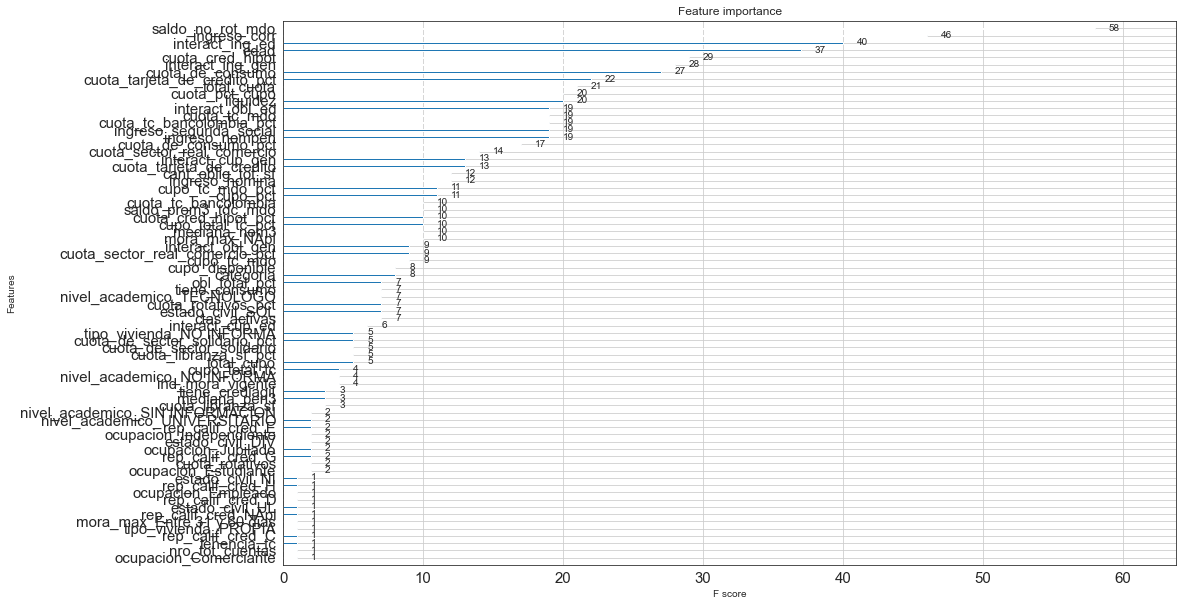

In [267]:
xgb.plot_importance(xgb_reg)

In [268]:
xgb_pred = xgb_reg.predict(X_test)
print("XGBoost: ", mean_absolute_percentage_error(xgb_pred, y_test))

elastic_pred=elastic_reg.predict(X_test)
print("Elastic Net: ", mean_absolute_percentage_error(elastic_pred, y_test))

lasso_pred= lasso_reg.predict(X_test)
print("Lasso: ", mean_absolute_percentage_error(lasso_pred, y_test))
      
ridge_pred=ridge_reg.predict(X_test)
print("Ridge: ", mean_absolute_percentage_error(ridge_pred, y_test))
      
catboost_pred=cat_reg.predict(X_test)
print("Catboost: ", mean_absolute_percentage_error(catboost_pred, y_test))  

ensemble_predictions = xgb_pred*0.3 + elastic_pred*0.1 + lasso_pred*0.1 +ridge_pred*0.2 +catboost_pred*0.3
print("Ensemble: ", mean_absolute_percentage_error(ensemble_predictions, y_test))

XGBoost:  0.05605553709209432
Elastic Net:  0.05705582961372813
Lasso:  0.05801737386947733
Ridge:  0.05703189708266366
Catboost:  0.0561615070172473
Ensemble:  0.05621359111030718


<AxesSubplot:xlabel='log_gasto_familiar', ylabel='Density'>

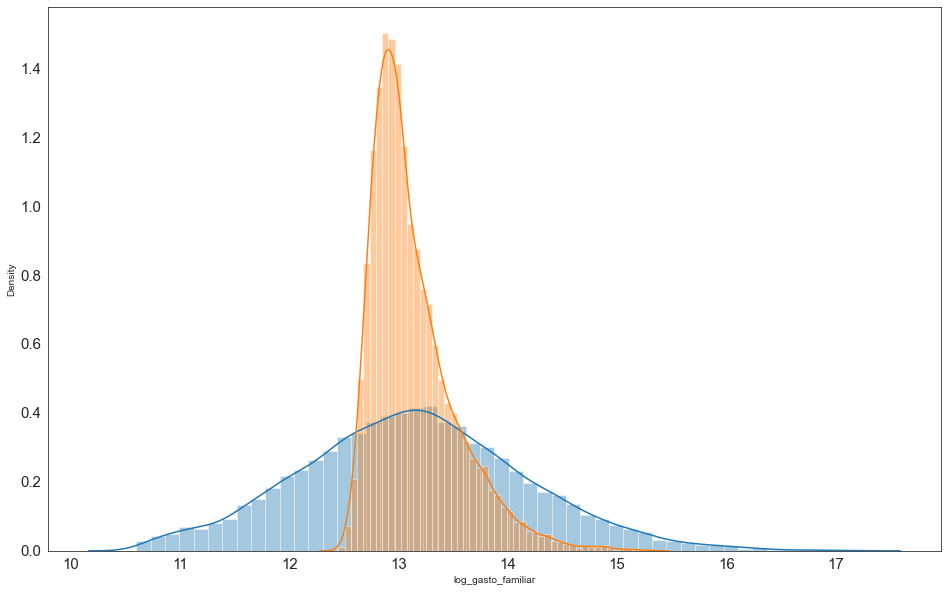

In [269]:
sns.distplot(y_test)
sns.distplot(ensemble_predictions)

# Ensemble Pipeline

In [ ]:
print(f"Hora de inicio: {datetime.now()}")
dates = [
    '201902', '201903', '201904', '201905', '201907', '201908', '201909',
    '201910', '201911', '202001', '202002', '202003', '202004', '202005',
    '202007', '202008', '202009', '202010', '202011'
]

test_df = pd.read_csv("test_cleaned.csv")
test_df['cuota_de_consumo'] = np.where(test_df['cuota_de_consumo'] <0 ,0, test_df['cuota_de_consumo'])
test_df_modeling = DataFramePreProcessor(test_df, test=True)
test_df_modeling.process()

last_predictions_list = []
y_tests = []
y_preds = []
mapes   = []
models = []
p = 0.1

random.seed(200)

with open('tuned_hyper_parameters.json') as f:
    tuned_hyperparameters = json.load(f)

for date in dates:
    print(f"Periodo {date}:")
    raw_dataframe = pd.read_csv(
             f"train_{date}_cleaned.csv",
             header=0,
             skiprows=lambda i: i>0 and random.random() > p
    ).drop("Unnamed: 0", axis=1)
    # raw_dataframe=raw_dataframe[raw_dataframe['gasto_familiar'] >0 ] 
    print(f"     Total rows in original_data {raw_dataframe.shape[0]}" )
    fe_dataframe = DataFramePreProcessor(raw_dataframe)
    fe_dataframe.process()
    X = fe_dataframe.modeling_dataframe.drop(["gasto_familiar",
                                         "log_gasto_familiar",
                                         "periodo"], axis=1)
    y = fe_dataframe.modeling_dataframe['log_gasto_familiar']
    print(f"     Total rows in transformed_data {fe_dataframe.modeling_dataframe.shape[0]}" )

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

    xgb_reg = xgb.XGBRegressor(**tuned_hyperparameters['xgb'])
    elastic_reg = ElasticNet(**tuned_hyperparameters['elasticnet'])
    lasso_reg=Lasso(**tuned_hyperparameters['lasso'])
    ridge_reg=Ridge(**tuned_hyperparameters['ridge'])
    cat_reg = CatBoostRegressor(**tuned_hyperparameters['catboost'])  
    
    xgb_reg.fit(X_train, y_train)
    elastic_reg.fit(X_train, y_train)
    cat_reg.fit(X_train, y_train, verbose=False)
    lasso_reg.fit(X_train, y_train)
    ridge_reg.fit(X_train, y_train)
    
    models.append([xgb_reg, elastic_reg, cat_reg, lasso_reg, ridge_reg])
    xgb_pred = xgb_reg.predict(X_test)
    elastic_pred = elastic_reg.predict(X_test)
    lasso_pred   = lasso_reg.predict(X_test)
    ridge_pred   = ridge_reg.predict(X_test)
    catboost_pred = cat_reg.predict(X_test)
    y_tests.append(y_test)
    y_preds.append([xgb_pred,elastic_pred, lasso_pred, ridge_pred, catboost_pred])
    ensemble_prediction=xgb_pred*0.3 + elastic_pred*0.1 +lasso_pred*0.1 +ridge_pred*0.2 +catboost_pred*0.3
    mape = mean_absolute_percentage_error(ensemble_prediction, y_test)
    mapes.append(mape)
    print(f"     MAPE {date}: ", mape )
    
    month_test = test_df_modeling.modeling_dataframe[
        test_df_modeling.modeling_dataframe['periodo'] == int(date)].reset_index(drop=True)
    predictions_df = month_test.drop(["periodo","id_registro"], axis=1)
    final_prediction_xgb=np.expm1(xgb_reg.predict(predictions_df))
    final_prediction_elastic=np.expm1(elastic_reg.predict(predictions_df))
    final_prediction_lasso=np.expm1(lasso_reg.predict(predictions_df))
    final_prediction_ridge=np.expm1(ridge_reg.predict(predictions_df))
    final_prediction_catboost=np.expm1(cat_reg.predict(predictions_df))
    final_prediction = final_prediction_xgb*0.3 + final_prediction_elastic*0.1 + final_prediction_lasso*0.1 + \
                        final_prediction_ridge*0.2 + final_prediction_catboost*0.3

    
    submission = pd.concat([month_test['id_registro'],pd.Series(final_prediction)], axis=1)
    submission.columns = ["id_registro", "gasto_familiar"]
    submission['gasto_familiar'] = submission['gasto_familiar'].round(4)
    submission['gasto_familiar'] = np.where(submission['gasto_familiar'] > 10000000, 10000000, submission['gasto_familiar'])
    
    last_predictions_list.append(submission)
print(f"Hora de finalizacion: {datetime.now()}")

Hora de inicio: 2021-01-23 00:33:12.839383
Periodo 201902:
     Total rows in original_data 104179
     Total rows in transformed_data 71621
     MAPE 201902:  0.06030517160064117
Periodo 201903:
     Total rows in original_data 107462
     Total rows in transformed_data 76489
     MAPE 201903:  0.05966851955481904
Periodo 201904:
     Total rows in original_data 108447
     Total rows in transformed_data 77410
     MAPE 201904:  0.059860052975339965
Periodo 201905:
     Total rows in original_data 108612
     Total rows in transformed_data 81764


In [245]:
predictions_df = test_df_modeling.modeling_dataframe.drop(["periodo","id_registro"], axis=1)
predictions_list = []
for model in models:
    final_predictions_xgb=np.expm1(model[0].predict(predictions_df))
    final_predictions_elastic=np.expm1(model[1].predict(predictions_df))
    final_predictions_lasso=np.expm1(model[2].predict(predictions_df))
    final_predictions_ridge=np.expm1(model[3].predict(predictions_df))
    final_predictions_catboost=np.expm1(model[4].predict(predictions_df))

    final_prediction=final_predictions_xgb*0.3+final_predictions_elastic*0.1 +final_predictions_lasso*0.1 +\
                       final_predictions_ridge*0.2 + final_predictions_catboost*0.5
    
    predictions_list.append(final_prediction)

In [257]:
stack =  predictions_list[0] +\
predictions_list[1] + \
predictions_list[2] + \
predictions_list[3] + \
predictions_list[4] + \
predictions_list[5] + \
predictions_list[6] + \
predictions_list[7] + \
predictions_list[8] + \
predictions_list[9] + \
predictions_list[10] + \
predictions_list[11] + \
predictions_list[12] + \
predictions_list[13] + \
predictions_list[14] + \
predictions_list[15] + \
predictions_list[16] + \
predictions_list[17] + \
predictions_list[18] 

final_prediction=stack / 19

In [258]:
submission = pd.concat([test_df['id_registro'],pd.Series(final_prediction)], axis=1)
submission.columns = ["id_registro", "gasto_familiar"]
submission['gasto_familiar'] = submission['gasto_familiar'].round(4)
submission['gasto_familiar'] = np.where(submission['gasto_familiar'] > 10000000, 10000000, submission['gasto_familiar'])
submission

,id_registro,gasto_familiar
0,4055#201902,662678.61420
1,12598#201902,539807.51590
2,23697#201902,727850.58410
3,23768#201902,617135.49500
4,7174#201902,885287.60740
...,...,...
281661,8596193#202011,568604.33260
281662,8616083#202011,1184305.59940
281663,8670207#202011,2518733.75760
281664,8677655#202011,848468.26910


In [259]:
submission.to_csv("submission_underground.csv", index=False)

In [260]:
np.mean(mapes)

0.057851993659592295

# GLM

In [106]:
# Fit Poisson regression of sat by weight\
glm_feat_formula = [
    'ingreso_corr_log',
    'cuota_cred_hipot_log',
    'cupo_total_tc_log',
    # 'cuota_tarjeta_de_credito_log',
    'cuota_de_consumo_log',
    'edad',
    # 'genero',
    'cuota_tc_bancolombia_log',
    'ind_annio',
    # 'cupo_tc_mdo_log',
   # 'edad:ingreso_corr',
   # 'edad*cuota_cred_hipot_log',
   #  'genero:ingreso_corr',
    'obl_total_pct',
    'ingreso_geo_alto',
    'ingreso_cero',
    'es_ciudad_principal'
]
glm_formula = 'np.log(gasto_familiar+1) ~ ' + ' + '.join(feature_cols)
glm_features = feature_cols + ['gasto_familiar']
glm_data = fe_dataframe.modeling_dataframe[glm_features]
# glm_data = glm_data[glm_data['gasto_familiar'] < 10000000]
model = glm( glm_formula, data = glm_data,
            family = sm.families.Poisson()).fit()

# Display model results
print(model.summary())

                     Generalized Linear Model Regression Results                      
Dep. Variable:     np.log(gasto_familiar + 1)   No. Observations:                78875
Model:                                    GLM   Df Residuals:                    78858
Model Family:                         Poisson   Df Model:                           16
Link Function:                            log   Scale:                          1.0000
Method:                                  IRLS   Log-Likelihood:            -2.0000e+05
Date:                        Wed, 20 Jan 2021   Deviance:                       56226.
Time:                                17:37:25   Pearson chi2:                 3.06e+04
No. Iterations:                             4                                         
Covariance Type:                    nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

# DL model

In [150]:
nn_model = Sequential()
nn_model.add(Dense(30, activation = 'relu', input_shape = (X.shape[1],))) #Primera capa oculta, justo después de la capa input de 3 variables
nn_model.add(Dropout(0.2))
nn_model.add(Dense(30, activation = 'relu'))
nn_model.add(BatchNormalization())
nn_model.add(Dense(30, activation = 'relu'))
nn_model.add(Dense(1))

nn_model.compile(optimizer = 'adam', loss = 'mse')
nn_model.fit(X_train, y_train, epochs=20)

Epoch 1/20
3355/3355 [==============================] - 5s 1ms/step - loss: 38.2824
Epoch 2/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.7941
Epoch 3/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.4961
Epoch 4/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.8006
Epoch 5/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.6510
Epoch 6/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.3454
Epoch 7/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.5507
Epoch 8/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.4897
Epoch 9/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.5531
Epoch 10/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.5549
Epoch 11/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.3447
Epoch 12/20
3355/3355 [==============================] - 4s 1ms/step - los

In [87]:
nn_predictions = nn_model.predict(X_test)
mean_absolute_percentage_error(nn_predictions, y_test)

0.8384442947941376

# test

In [92]:
class PrepareSubmission:
    
    def __init__(self, dataframe, model):
        self.test_dataframe = dataframe
        self.model = model
     
    def makePrediction(self, dataframe)
        test_df_modeling = DataFramePreProcessor(test_df, test=True)
        test_df_modeling.process()
        final_predictions=xgb_reg.predict(test_df_modeling.modeling_dataframe[feature_cols])
    
    
    def prepareSubmissionDF(self, dataframe):
        submission = pd.concat([test_df['id_registro'],pd.Series(final_predictions)], axis=1)
        submission.columns = ["id_registro", "gasto_familiar"]
    
    
    def submit(self):
        submission.to_csv("submission_underground.csv", index=False)

# Compare predictions


In [250]:
best_submission = pd.read_csv("submission_underground XGboost + ElasticNET.csv")
best_submission_2 =  pd.read_csv("submission_underground XGBoost+17meses+Boxcox+Log.csv")


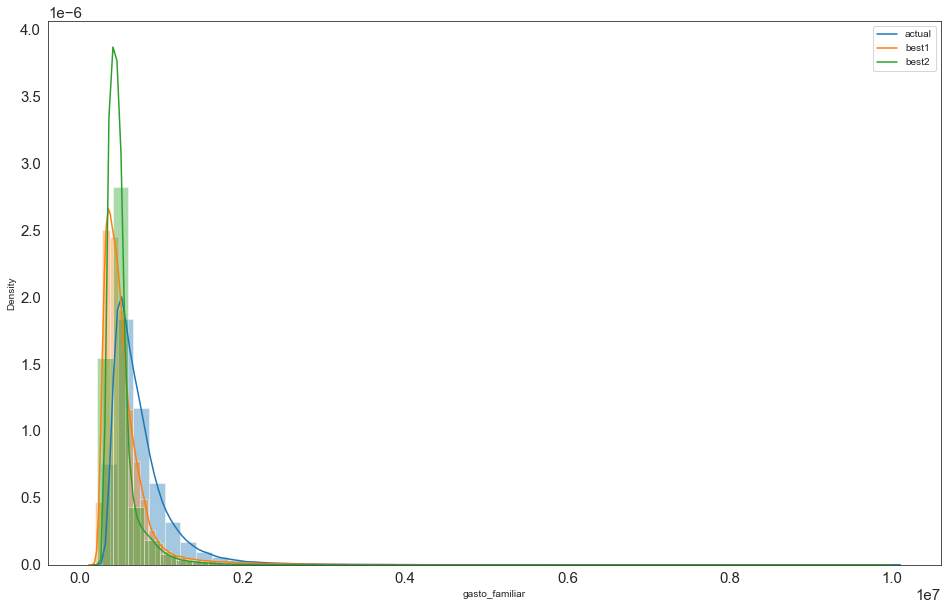

In [261]:
sns.distplot(submission['gasto_familiar'])
#sns.distplot(fe_dataframe.modeling_dataframe['gasto_familiar'])

sns.distplot(best_submission_2[best_submission_2['gasto_familiar'] < 10000000]['gasto_familiar'])
sns.distplot(best_submission[best_submission['gasto_familiar'] < 10000000]['gasto_familiar'])

plt.legend(['actual', 'best1', 'best2'])

In [252]:
submission['gasto_familiar'].describe()

count      281666.00000
mean       748651.79052
std        496318.03296
min        253313.14930
25%        498344.50215
50%        639680.01155
75%        860155.16252
max     104107969.83870
Name: gasto_familiar, dtype: float64

In [ ]:
def submit_predictions(name,model):
    df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_features.csv'), 
                                   index_col='match_id_hash')
    X_test = df_test_features.values
    y_test_pred = model.predict_proba(X_test)[:, 1]

    df_submission = pd.DataFrame({'radiant_win_prob': y_test_pred}, 
                                 index=df_test_features.index)
    submission_filename = 'submission_{}.csv'.format(name)
    df_submission.to_csv(submission_filename)
    print('Submission saved to {}'.format(submission_filename))
    
submit_predictions('simple_cat_boost',model=base_model)


In [270]:
np.log(104107969.83870)

18.46093909010424